# Predicción de Enlaces y recomendacion con Node2Vec

In [ ]:
!pip install arxiv
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=88dde6735333f6bff79b24185771294561e541860aabd226a118a8fdd2329550
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda

## ¿Qué es la Predicción de Enlaces?
Existen muchas maneras de resolver problemas en motores de recomendación. Estas soluciones varían desde enfoques algorítmicos, algoritmos de predicción de enlaces, soluciones basadas en embeddings, etc. La predicción de enlaces también se conoce como completamiento de grafos, un problema común en la teoría de grafos. En su forma más simple, dado una red, quieres saber si debería haber un enlace entre un par de nodos. Esta definición cambia ligeramente dependiendo del tipo de red con la que estás trabajando. Un grafo dirigido o multigrafo puede tener interpretaciones ligeramente diferentes, pero el concepto fundamental de identificar enlaces faltantes en una red permanece.

Los problemas en la predicción de enlaces también son bastante comunes al tratar con redes temporales (redes que cambian a lo largo del tiempo). Dada una red G en el paso de tiempo t, querrías predecir los enlaces del grafo G en el paso de tiempo t+1.

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec as n2v

In [ ]:
# constants
queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

# Obtener Datos

Queremos utilizar la API de Arxiv para recopilar información sobre los últimos trabajos de investigación basados en las consultas que hemos identificado anteriormente. Esto nos permitirá luego crear una red a partir de los datos de estos trabajos de investigación y entonces intentaremos predecir enlaces en esa red. Para los fines de este artículo, buscaré un máximo de 1000 resultados por consulta, pero tú no tienes que sujetarte a las mismas restricciones. La API de Arxiv permite a los usuarios obtener hasta 300,000 resultados por consulta. La función descrita a continuación generará un CSV recopilando la siguiente información:
```'title', 'date', 'article_id', 'url', 'main_topic', 'all_topics', 'authors', 'year'```
Puedes obtener más información como `links, summary, article` pero decidí no hacerlo ya que esas características realmente no serán utilizadas para los fines de este análisis y tutorial.

Para referencia sobre la API de Arxiv, puedes encontrar su documentación detallada aquí: https://arxiv.org/help/api/user-manual

In [ ]:
def search_arxiv(queries, max_results = 100):
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.

    params:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000

    returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed.
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`

    example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)

    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)

    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year

    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d

In [ ]:
%%time
research_df = search_arxiv(
    queries = queries,
    max_results = 100
)
research_df.shape

<ipython-input-4-03fcdcd354a4>:37: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for res in search.results():


CPU times: user 2.41 s, sys: 40.3 ms, total: 2.45 s
Wall time: 8.56 s


(650, 8)

In [ ]:
research_df.head()

,title,date,article_id,url,main_topic,all_topics,authors,year
0,Position: A Call to Action for a Human-Centere...,2024-06-05 15:05:24+00:00,0,http://arxiv.org/pdf/2406.03348v1,cs.LG,[cs.LG],"[Marius Lindauer, Florian Karl, Anne Klier, Ju...",2024
1,AI-based Classification of Customer Support Ti...,2024-06-03 21:13:02+00:00,1,http://arxiv.org/pdf/2406.01789v1,cs.LG,"[cs.LG, cs.AI, cs.CL, cs.HC, I.2; I.2.7; K.6]","[Mario Truss, Stephan Boehm]",2024
2,Adaptive $Q$-Network: On-the-fly Target Select...,2024-05-25 11:57:43+00:00,2,http://arxiv.org/pdf/2405.16195v1,cs.LG,"[cs.LG, cs.AI]","[Théo Vincent, Fabian Wahren, Jan Peters, Bori...",2024
3,Using Combinatorial Optimization to Design a H...,2024-05-15 11:13:39+00:00,3,http://arxiv.org/pdf/2405.13020v1,cs.CL,"[cs.CL, cs.AI]","[Samuel Ackerman, Eitan Farchi, Rami Katan, Or...",2024
4,Squeezing Lemons with Hammers: An Evaluation o...,2024-05-13 11:43:38+00:00,4,http://arxiv.org/pdf/2405.07662v1,cs.LG,"[cs.LG, cs.AI]","[Ricardo Knauer, Erik Rodner]",2024


## Generar Red

Ahora que hemos obtenido los datos utilizando la API de Arxiv, podemos generar una red. La estructura de la red será la siguiente: los nodos serán los `article_ids` y los enlaces serán todos los temas que conectan un par de artículos. Por ejemplo, el `article_id 1` con los temas `astro-física y estadísticas` puede estar conectado al `article_id 10` con el tema `estadísticas` y al `article_id 7` con los temas `astro-física, matemáticas`. Esta será una red de múltiples enlaces donde cada enlace tendrá un peso de 1.

In [ ]:
def generate_network(df, node_col = 'article_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.

    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network

    returns:
        A networkx graph corresponding to the input dataset

    example:
        generate_network(
            research_df,
            node_col = 'article_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges

    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

In [ ]:
all_tp = research_df.explode('all_topics').copy()

In [ ]:
%%time
tp_nx = generate_network(
    all_tp,
    node_col = 'article_id',
    edge_col = 'all_topics'
)

CPU times: user 1.27 s, sys: 8.74 ms, total: 1.28 s
Wall time: 1.83 s


In [ ]:
print(nx.info(tp_nx))

Graph with 584 nodes and 33541 edges


<ipython-input-10-5457b312971a>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(tp_nx))


In [ ]:
%%time
research_nx = generate_network(
    research_df,
    node_col = 'article_id',
    edge_col = 'main_topic'
)

CPU times: user 1.05 s, sys: 8.82 ms, total: 1.05 s
Wall time: 1.47 s


In [ ]:
print(nx.info(research_nx))

Graph with 584 nodes and 12862 edges


<ipython-input-12-7ae1bf0e2c36>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(research_nx))


## Node2Vec

Este componente cubrirá la ejecución de node2vec en el grafo generado anteriormente y la creación de los embeddings de nodos asociados para esa red. Estos embeddings desempeñarán un papel crucial en lo que sigue, ya que son las características principales necesarias para construir un modelo de predicción de enlaces.

In [ ]:
%time g_emb = n2v(tp_nx, dimensions=16)

Computing transition probabilities:   0%|          | 0/584 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

CPU times: user 1min 11s, sys: 658 ms, total: 1min 11s
Wall time: 1min 24s


In [ ]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [ ]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

In [ ]:
input_node = '1'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

('440', 0.950953483581543)
('475', 0.9501842260360718)
('516', 0.948316752910614)
('518', 0.9440028667449951)
('434', 0.9420174956321716)
('206', 0.9409930109977722)
('472', 0.9392722845077515)
('512', 0.9268742799758911)
('338', 0.8932715654373169)
('427', 0.8201966285705566)


## Generar DataFrame de Embeddings

In [ ]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in tp_nx.nodes()],
        index = tp_nx.nodes
    )
)

In [ ]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.196941,-0.124033,-0.601421,0.545209,0.841145,0.226566,1.148397,0.343607,-0.319765,0.223038,0.051716,-0.365541,0.590912,-1.172069,-0.049248,0.979324
1,-0.221081,0.229598,0.083973,1.505110,0.358578,0.538549,1.209605,0.053599,0.437247,-0.466862,0.091293,0.027160,0.262387,-0.549673,-0.417684,0.066431
2,-0.361888,0.074789,0.078418,0.721170,0.320222,0.336538,1.125500,0.210581,0.506290,0.187148,0.218859,-0.876790,0.348352,-1.359215,0.332504,0.247158
3,0.272834,-0.062326,-0.396623,0.871157,0.800673,1.245440,0.856619,0.283148,0.715484,-0.480800,0.195614,0.627340,0.039687,-1.248271,0.495762,-0.598750
4,-0.479877,0.045342,0.095946,0.566142,0.375811,0.341864,1.157948,0.197043,0.465209,0.233730,0.160235,-0.658064,0.378449,-1.376188,0.264785,0.195926


## Recomendación con medidas de distancias

Ahora que tenemos un vector de embedding representando cada nodo en la red, podemos utilizar medidas de distancia como la similitud coseno, distancia euclidiana, distancia manhattan, etc., para medir la cantidad de distancia entre nodos. La suposición que estamos haciendo al usar estas medidas de distancia es que los nodos que están en proximidad cercana entre sí también deberían tener un enlace conectándolos. Esta es una buena suposición ya que node2vec intenta preservar la estructura inicial del grafo de entrada original. Ahora podemos, esencialmente, escribir código para medir los niveles de similitud entre dos vectores usando la similitud coseno (o una medida de distancia diferente) e identificar pares de nodos que actualmente no tienen un enlace entre ellos pero tienen una gran similitud y deberían crear un enlace entre ellos. Esta interpretación puede ser diferente para grafos múltiples / ponderados / dirigidos. Elige y utiliza una medida de similitud apropiada para la red y el problema que estás tratando de resolver. También ten en cuenta que diferentes medidas tienen diferentes interpretaciones; para este problema, querrás elegir los puntajes máximos de similitud coseno, mientras que si usaras algo como la distancia euclidiana, querrías elegir la mínima distancia entre dos vectores.

Como nota al margen, quiero mencionar que la maldición de la dimensionalidad es rampante al resolver este tipo de problemas. Es especialmente problemático al usar la distancia euclidiana en particular para medir la distancia entre vectores en dimensiones más altas. El término "dimensiones altas" es amplio y abierto a interpretación, el umbral para que una dimensión sea "alta" no está estrictamente definido y varía de problema a problema. Sin entrar demasiado en la matemática detrás de las cosas, la distancia euclidiana no es una buena medida para usar con vectores dispersos o de alta dimensión. Puedes consultar este post en Stack Exchange que explica el razonamiento matemático de por qué este es el caso:

- https://stats.stackexchange.com/questions/29627/euclidean-distance-is-usually-not-good-for-sparse-data-and-more-general-case
- https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions

Para más información sobre la maldición de la dimensionalidad, consulta este [artículo](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) del departamento de Ciencias de la Computación de la Universidad de Washington.

In [ ]:
def predict_links(G, df, article_id, N):
    '''
    This function will predict the top N links a node (article_id) should be connected with
    which it is not already connected with in G.

    params:
        G (Netowrkx Graph) : The network used to create the embeddings
        df (DataFrame) : The dataframe which has embeddings associated to each node
        article_id (Integer) : The article you're interested
        N (Integer) : The number of recommended links you want to return

    returns:
        This function will return a list of nodes the input node should be connected with.
    '''

    # separate target article with all others
    article = df[df.index == article_id]

    # other articles are all articles which the current doesn't have an edge connecting
    all_nodes = G.nodes()
    other_nodes = [n for n in all_nodes if n not in list(G.adj[article_id]) + [article_id]]
    other_articles = df[df.index.isin(other_nodes)]

    # get similarity of current reader and all other readers
    sim = cosine_similarity(article, other_articles)[0].tolist()
    idx = other_articles.index.tolist()

    # create a similarity dictionary for this user w.r.t all other users
    idx_sim = dict(zip(idx, sim))
    idx_sim = sorted(idx_sim.items(), key=lambda x: x[1], reverse=True)

    similar_articles = idx_sim[:N]
    articles = [art[0] for art in similar_articles]
    return articles

In [ ]:
predict_links(G = tp_nx, df = emb_df, article_id = 1, N = 10)

[400, 347, 411, 383, 444, 344, 177, 409, 41, 142]

## Modelando una Recomendación de Base

En esta sección vamos a construir un clasificador binario para predecir la probabilidad de que un par de aristas estén conectadas o no. Para hacer esto, primero necesitamos identificar todos los pares de nodos que pueden formar una arista e identificar el subconjunto de esos pares que ya tienen una arista entre ellos en la red original. Luego podemos combinar los embeddings (a través de la adición de vectores) asociados a todas las posibles aristas y pasar eso a una función de división de entrenamiento y prueba para generar particiones de entrenamiento y prueba para introducir en un modelo de clasificación.

El modelo que usaré para este tutorial será un clasificador de potenciación de gradiente, para tus propios problemas y experimentos te aconsejo probar una variedad de clasificadores diferentes y seleccionar el que mejor rendimiento general ofrezca. Estamos construyendo un clasificador binario, sin embargo, en casi todas las situaciones, independientemente de los datos de entrada o la red, habrá un desequilibrio de clases en este clasificador. Dado que estamos tomando todas las combinaciones posibles de aristas que se pueden formar en la red, el resultado es N^N (donde N es el número de nodos en la red), esto es exponencialmente grande. La única manera de que esto no sea un clasificador binario es si tu grafo ya está casi completamente conectado.

In [ ]:
unique_nodes = list(tp_nx.nodes())

In [ ]:
%time all_possible_edges = [(x,y) for (x,y) in product(unique_nodes, unique_nodes)]

CPU times: user 51.8 ms, sys: 14 ms, total: 65.7 ms
Wall time: 68.6 ms


In [ ]:
len(all_possible_edges)

341056

In [ ]:
%%time
edge_features = [
    (mdl.wv.get_vector(str(i)) + mdl.wv.get_vector(str(j))) for i,j in all_possible_edges
]

CPU times: user 1.08 s, sys: 109 ms, total: 1.19 s
Wall time: 1.2 s


In [ ]:
edges = list(tp_nx.edges())

In [ ]:
%time is_con = [1 if e in edges else 0 for e in all_possible_edges]

CPU times: user 3min 56s, sys: 819 ms, total: 3min 57s
Wall time: 4min


In [ ]:
sum(is_con)

33541

## Entrenar el Modelo

In [ ]:
# get training and target data
X = np.array(edge_features)
y = is_con

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
%%time
# GBC classifier
clf = GradientBoostingClassifier()

# train the model
clf.fit(x_train, y_train)

CPU times: user 4min 28s, sys: 858 ms, total: 4min 29s
Wall time: 4min 32s


GradientBoostingClassifier()

## Performance del Modelo

Cuando tratamos con desequilibrios de clases, no podemos mirar las medidas de precisión tradicionales para evaluar el rendimiento del modelo. Esto se debe a que si el modelo predice continuamente la clase que tiene mayor cantidad de datos, entonces, independientemente de que el modelo nunca prediga la otra clase, aún así logrará un alto nivel de precisión. La manera de combatir esto es usar medidas como el Coeficiente de Correlación de Matthews.

```quote
El MCC es, en esencia, un valor de coeficiente de correlación entre -1 y +1. Un coeficiente de +1 representa una predicción perfecta, 0 una predicción aleatoria promedio y -1 una predicción inversa. Esta estadística también es conocida como el coeficiente phi.
```
- https://es.wikipedia.org/wiki/Coeficiente_phi

In [ ]:
y_pred = clf.predict(x_test)
y_true = y_test

In [ ]:
y_pred = clf.predict(x_test)
x_pred = clf.predict(x_train)
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, x_pred)
print("Testing Accuracy : ", test_acc)
print("Training Accuracy : ", train_acc)

Testing Accuracy :  0.8990588074318051
Training Accuracy :  0.9024122577375293


In [ ]:
print("MCC Score : ", matthews_corrcoef(y_true, y_pred))

MCC Score :  0.2926505545117989


In [ ]:
print(confusion_matrix(y_pred,y_test))

[[89515  7585]
 [ 2743  2474]]


In [ ]:
print("Test Classification Report : ")
print(classification_report(y_test, clf.predict(x_test)))

Test Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     92258
           1       0.47      0.25      0.32     10059

    accuracy                           0.90    102317
   macro avg       0.70      0.61      0.63    102317
weighted avg       0.88      0.90      0.88    102317



## Generar Predicciones

In [ ]:
pred_ft = [(mdl.wv.get_vector(str('42'))+mdl.wv.get_vector(str('210')))]
print(clf.predict(pred_ft)[0])

0


In [ ]:
print(clf.predict_proba(pred_ft))

[[0.98889106 0.01110894]]


Como puedes ver claramente, este es un modelo de bajo rendimiento para la tarea asignada (reflejado por el MCC, la puntuación F, el recall y la precisión). Pero está bien, ya que este artículo fue simplemente con fines educativos. No todos los enfoques que utilizas para resolver un problema dado resultarán o funcionarán; muchas veces no es culpa del enfoque, sino más bien de los datos. En el caso de este tutorial, definitivamente los datos eran el problema, ya que solo estaba utilizando una pequeña muestra de una red de investigación real que estaría disponible si raspase datos de Arxiv para obtener más datos. Pero hacer eso también aumentaría la complejidad computacional de muchos componentes diferentes de este artículo (como ejecutar node2vec, generar todos los posibles pares de aristas, entrenar el modelo, etc.).

La regla general que la mayoría de los científicos de datos sigue al resolver problemas es que si las soluciones simples funcionan, entonces las soluciones más complejas también deberían funcionar. Las soluciones más simples en sistemas de recomendación que involucran filtrado colaborativo o basado en contenido suelen ser bastante fáciles de implementar y ofrecen resultados relativamente informativos e indicaciones sobre si una solución más compleja también funcionaría para resolver este problema. A menudo no es lo mejor lanzar una red neuronal al problema (como node2vec) por varias razones (como el tiempo de entrenamiento, la interpretabilidad, el tiempo de inferencia del modelo, etc.).

# **Solución propuesta de Actividad:**

# **Recopilación de Datos**:

* Utilizar la función search arxiv para obtener datos de artículos académicos
desde la API de Arxiv. Seleccionar temas de interés distintos a los mostrados y recopilar datos como título, fecha, identificador del artículo, URL, y temas principales.
* Guardar los datos recopilados en un DataFrame.

**Importación de librerías**

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec as n2v

**Definición de constantes:**

In [ ]:
# constants
queries = [
    'mlops', 'machinelearning', 'data', 'artificial intelligence','graph neural', 'neural network', 'detection object', 'reinforcement learning'
]

**Obtención de datos:**

In [ ]:
%%time
research_df = search_arxiv(
    queries = queries,
    max_results = 200
)
research_df.shape

<ipython-input-4-03fcdcd354a4>:37: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for res in search.results():


CPU times: user 3.06 s, sys: 57.9 ms, total: 3.12 s
Wall time: 30.5 s


(1312, 8)

In [ ]:
research_df.head()

,title,date,article_id,url,main_topic,all_topics,authors,year
0,Automating the Training and Deployment of Mode...,2024-05-16 05:36:28+00:00,0,http://arxiv.org/pdf/2405.09819v1,cs.SE,"[cs.SE, cs.LG]","[Penghao Liang, Bo Song, Xiaoan Zhan, Zhou Che...",2024
1,DeepFMEA -- A Scalable Framework Harmonizing P...,2024-05-13 09:41:34+00:00,1,http://arxiv.org/pdf/2405.08041v1,cs.LG,"[cs.LG, cs.AI]","[Christoph Netsch, Till Schöpe, Benedikt Schin...",2024
2,Automating Code Adaptation for MLOps -- A Benc...,2024-05-10 22:18:43+00:00,2,http://arxiv.org/pdf/2405.06835v1,cs.LG,"[cs.LG, cs.AI, cs.SE]","[Harsh Patel, Buvaneswari A. Ramanan, Manzoor ...",2024
3,Towards Architecting Sustainable MLOps: A Self...,2024-04-06 09:38:04+00:00,3,http://arxiv.org/pdf/2404.04572v1,cs.SE,[cs.SE],"[Hiya Bhatt, Shrikara Arun, Adyansh Kakran, Ka...",2024
4,An AI-Native Runtime for Multi-Wearable Enviro...,2024-03-26 16:50:44+00:00,4,http://arxiv.org/pdf/2403.17863v1,cs.DC,[cs.DC],"[Chulhong Min, Utku Günay Acer, SiYoung Jang, ...",2024


# **Generación del Grafo**

* Implementar la función generate network para crear un grafo utilizando NetworkX donde cada nodo representa un artículo y cada enlace representa un tema compartido entre dos artículos.
* Visualizar el grafo para entender su estructura.

**Generación de datos:**

In [ ]:
all_tp = research_df.explode('all_topics').copy()

In [ ]:
%%time
tp_nx = generate_network(
    all_tp,
    node_col = 'article_id',
    edge_col = 'all_topics'
)

CPU times: user 1.2 s, sys: 18 ms, total: 1.22 s
Wall time: 1.22 s


In [ ]:
print(nx.info(tp_nx))

Graph with 751 nodes and 65441 edges


<ipython-input-44-5457b312971a>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(tp_nx))


In [ ]:
%%time
research_nx = generate_network(
    research_df,
    node_col = 'article_id',
    edge_col = 'main_topic'
)

CPU times: user 1.2 s, sys: 29.9 ms, total: 1.23 s
Wall time: 1.23 s


In [ ]:
print(nx.info(research_nx))

Graph with 751 nodes and 25223 edges


<ipython-input-46-7ae1bf0e2c36>:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(research_nx))


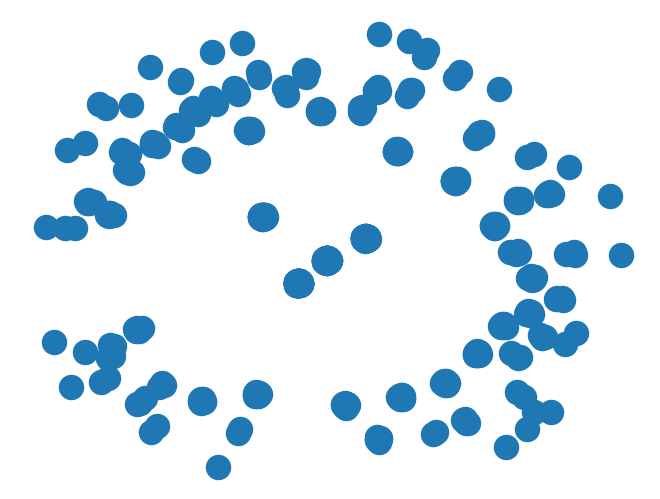

In [ ]:
nx.draw(research_nx)

# **Aplicación de Node2Vec**

* Utilizar la biblioteca Node2Vec para generar embeddings para cada nodo del grafo.
* Configurar parámetros como la dimensión del embedding y el tamaño de la ventana.


**Node2Vec**

In [ ]:
%time g_emb = n2v(tp_nx, dimensions=16)

Computing transition probabilities:   0%|          | 0/751 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:24<00:00,  2.50s/it]

CPU times: user 2min 51s, sys: 1.43 s, total: 2min 53s
Wall time: 2min 55s


In [ ]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [ ]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

In [ ]:
input_node = '1'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

('420', 0.9961740970611572)
('144', 0.9955465793609619)
('449', 0.9953691363334656)
('333', 0.9941903948783875)
('407', 0.9939141869544983)
('450', 0.9936825037002563)
('459', 0.9929540157318115)
('443', 0.9927427172660828)
('442', 0.9926936626434326)
('265', 0.9926844835281372)


In [ ]:
#resultado = research_df[research_df['article_id'].isin(('310', '443', '363', '343', '392', '318', '421', '442', '472', '144'))]
resultado = research_df[research_df['article_id'].isin(('403', '379', '7', '374', '357', '354', '337', '424', '325', '440'))]
resultado.head(10)

,title,date,article_id,url,main_topic,all_topics,authors,year


# **Predicción de Enlaces**

* Implementar una función predict links que utiliza la similitud coseno entre embeddings para sugerir nuevos enlaces en el grafo.
* Evaluar los resultados observando qué nuevos enlaces se sugieren y cuán relevantes son.

**Generar Dataframe de Embedding**

In [ ]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in tp_nx.nodes()],
        index = tp_nx.nodes
    )
)

In [ ]:
emb_df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.440030,-0.541564,-0.785095,0.133966,0.031293,0.037844,1.690834,-0.510405,0.301066,-0.171575,-0.115805,-0.176820,0.195396,-0.794328,1.202434,0.916933
1,-0.039499,-0.669173,-0.541264,0.220021,0.222272,1.228651,0.855091,0.394413,0.102042,0.396742,-0.277757,-0.615394,0.313241,-1.091415,0.226789,0.091853
2,-0.512470,-0.871931,-0.415896,0.067229,-0.051252,0.782417,1.035098,0.012746,0.486603,-0.300974,-0.235358,-0.707878,0.737775,-0.733439,0.802521,0.101632
3,-1.183259,-0.104342,0.682620,0.425491,-0.083818,0.541523,1.649198,0.074607,1.284698,-0.045877,-1.621385,0.024214,0.124308,-1.247914,0.420714,2.409271
4,0.164216,-0.534739,0.532922,0.297901,-0.221626,0.000709,0.624367,0.178414,-0.111709,-0.264015,-0.628188,-0.102729,0.506032,-1.553535,0.120367,0.730276
5,-1.119119,0.031489,0.668770,0.560935,0.050594,0.470541,1.660782,-0.059140,1.453807,-0.039455,-1.607845,0.209553,0.118422,-1.390679,0.198095,2.356980
6,-0.601759,-0.749451,1.253915,-0.045522,0.034826,0.526857,0.706593,-0.482874,0.816983,-0.302887,-0.150451,-0.411339,0.284914,-0.342310,-0.288491,1.283225
7,-0.093687,-0.696801,-0.461326,0.005907,0.223802,1.204610,0.841987,0.346559,0.101155,0.351009,-0.350076,-0.619509,0.428141,-1.039483,0.153954,0.072161
8,-0.908412,-0.087347,0.653700,0.457490,0.064390,0.418288,1.615453,-0.105849,1.477449,-0.090590,-1.650268,0.173203,0.076700,-1.347264,0.300173,2.313184
9,0.019575,-0.522294,-0.433739,-0.204458,0.328149,0.982477,0.628562,0.403621,-0.063704,0.319473,-0.523677,-0.751289,0.505885,-1.073526,-0.079122,0.054952


**Recomendación con medidas de distancias**

In [ ]:
valores_predict = predict_links(G = tp_nx, df = emb_df, article_id = 1, N = 10)

In [ ]:
resultado = research_df[research_df['article_id'].isin(valores_predict)]
resultado.head(10)

,title,date,article_id,url,main_topic,all_topics,authors,year
4,An AI-Native Runtime for Multi-Wearable Enviro...,2024-03-26 16:50:44+00:00,4,http://arxiv.org/pdf/2403.17863v1,cs.DC,[cs.DC],"[Chulhong Min, Utku Günay Acer, SiYoung Jang, ...",2024
150,CHIQ: Contextual History Enhancement for Impro...,2024-06-07 15:23:53+00:00,150,http://arxiv.org/pdf/2406.05013v1,cs.IR,[cs.IR],"[Fengran Mo, Abbas Ghaddar, Kelong Mao, Mehdi ...",2024
225,"Approximated Coded Computing: Towards Fast, Pr...",2024-06-07 08:46:32+00:00,225,http://arxiv.org/pdf/2406.04747v1,cs.DC,[cs.DC],"[Houming Qiu, Kun Zhu, Nguyen Cong Luong, Dusi...",2024
571,QAGCF: Graph Collaborative Filtering for Q&A R...,2024-06-07 10:52:37+00:00,498,http://arxiv.org/pdf/2406.04828v1,cs.IR,[cs.IR],"[Changshuo Zhang, Teng Shi, Xiao Zhang, Yanpin...",2024
598,PolySAT: Word-level Bit-vector Reasoning in Z3,2024-06-07 07:15:22+00:00,510,http://arxiv.org/pdf/2406.04696v1,cs.LO,[cs.LO],"[Jakob Rath, Clemens Eisenhofer, Daniela Kaufm...",2024
624,Continuous Attractor Networks for Laplace Neur...,2024-06-06 23:06:38+00:00,526,http://arxiv.org/pdf/2406.04545v1,q-bio.NC,[q-bio.NC],"[Bryan C. Daniels, Marc W. Howard]",2024
704,Beyond Similarity: Personalized Federated Reco...,2024-06-06 10:17:52+00:00,585,http://arxiv.org/pdf/2406.03933v1,cs.CR,"[cs.CR, cs.IR]","[Honglei Zhang, Haoxuan Li, Jundong Chen, Sen ...",2024
768,QAGCF: Graph Collaborative Filtering for Q&A R...,2024-06-07 10:52:37+00:00,498,http://arxiv.org/pdf/2406.04828v1,cs.IR,[cs.IR],"[Changshuo Zhang, Teng Shi, Xiao Zhang, Yanpin...",2024
794,EAIA: An Efficient and Anonymous Identity Auth...,2024-06-07 07:26:09+00:00,607,http://arxiv.org/pdf/2406.04705v1,cs.CR,[cs.CR],"[Qianmin Du, Jianhong Zhou, Maode Ma]",2024
825,Continuous Attractor Networks for Laplace Neur...,2024-06-06 23:06:38+00:00,526,http://arxiv.org/pdf/2406.04545v1,q-bio.NC,[q-bio.NC],"[Bryan C. Daniels, Marc W. Howard]",2024


**Modelando una Recomendación de Base**

In [ ]:
unique_nodes = list(tp_nx.nodes())

In [ ]:
%time all_possible_edges = [(x,y) for (x,y) in product(unique_nodes, unique_nodes)]

CPU times: user 77 ms, sys: 12 ms, total: 89 ms
Wall time: 91.3 ms


In [ ]:
len(all_possible_edges)

564001

In [ ]:
%%time
edge_features = [
    (mdl.wv.get_vector(str(i)) + mdl.wv.get_vector(str(j))) for i,j in all_possible_edges
]

CPU times: user 1.92 s, sys: 82.7 ms, total: 2 s
Wall time: 2.02 s


In [ ]:
edges = list(tp_nx.edges())

In [ ]:
%time is_con = [1 if e in edges else 0 for e in all_possible_edges]

CPU times: user 12min 55s, sys: 2.7 s, total: 12min 57s
Wall time: 13min 4s


In [ ]:
sum(is_con)

65441

# **Modelo de Clasificación para la Recomendación**

* Utilizar embeddings generados para construir un clasificador distinto al gradient boosting que prediga si debería existir un enlace entre dos nodos.
* Entrenar el modelo con un conjunto de datos de entrenamiento y evaluar su rendimiento con un conjunto de datos de prueba.

**Entrenar el Modelo**

In [ ]:
# get training and target data
X = np.array(edge_features)
y = is_con

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**Performance del modelo**

In [ ]:
def perfomance_modelo():
  y_pred = clf.predict(x_test)
  y_true = y_test

  y_pred = clf.predict(x_test)
  x_pred = clf.predict(x_train)
  test_acc = accuracy_score(y_test, y_pred)
  train_acc = accuracy_score(y_train, x_pred)
  print("Testing Accuracy : ", test_acc)
  print("Training Accuracy : ", train_acc)

  print("MCC Score : ", matthews_corrcoef(y_true, y_pred))
  print(confusion_matrix(y_pred,y_test))

  print("Test Classification Report : ")
  print(classification_report(y_test, clf.predict(x_test)))

**Generar predicciones**

In [ ]:
def generar_prediccion():
  pred_ft = [(mdl.wv.get_vector(str('42'))+mdl.wv.get_vector(str('210')))]
  print(clf.predict(pred_ft)[0])

  print(clf.predict_proba(pred_ft))

**USANDO RandomForestClassifier**

In [ ]:
%%time
clf = RandomForestClassifier()

# train the model
clf.fit(x_train, y_train)

In [ ]:
# Vemos el performance con el modelo RandomForestClassifier
perfomance_modelo()

Testing Accuracy :  0.8027316623424211
Training Accuracy :  0.9185891590678825
MCC Score :  0.023961179718068694
[[133212  16849]
 [ 16529   2611]]
Test Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    149741
           1       0.14      0.13      0.14     19460

    accuracy                           0.80    169201
   macro avg       0.51      0.51      0.51    169201
weighted avg       0.80      0.80      0.80    169201



In [ ]:
generar_prediccion()

0
[[1. 0.]]


**USANDO GradientBoostingClassifier (solo para comparar resultado)**

In [ ]:
%%time
clf = GradientBoostingClassifier()

# train the model
clf.fit(x_train, y_train)

In [ ]:
# Vemos el performance con el modelo GradientBoostingClassifier
perfomance_modelo()

Testing Accuracy :  0.8820219738654027
Training Accuracy :  0.8843211752786221
MCC Score :  0.3165099653991904
[[143451  13672]
 [  6290   5788]]
Test Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93    149741
           1       0.48      0.30      0.37     19460

    accuracy                           0.88    169201
   macro avg       0.70      0.63      0.65    169201
weighted avg       0.86      0.88      0.87    169201



In [ ]:
generar_prediccion()

# **Evaluación y Discusión (RandomForestClassifier)**

* Discutir los resultados obtenidos, interpretar la importancia de los embeddings en la predicción de enlaces y sugerir mejoras para el modelo.

  **Respuesta**

 **Discusión de Resultados**

  Los resultados obtenidos muestran que el modelo logra una precisión de prueba del 80%, lo que indica que predice correctamente el 80% de las veces en el conjunto de prueba. Sin embargo, se observa una dificultad considerable para predecir la clase positiva (enlaces) con baja precisión y recall para esta clase. El coeficiente de correlación de Matthews (MCC) cercano a cero sugiere una correlación limitada entre las predicciones y las etiquetas reales.

  **Importancia de los Embeddings**

  Los embeddings generados por Node2Vec desempeñan un papel crucial en la predicción de enlaces, ya que representan cada nodo en un espacio de características continuo, capturando la estructura y las relaciones del grafo. La calidad de estos embeddings es fundamental, ya que nodos cercanos en el grafo deberían tener embeddings similares, facilitando la predicción de enlaces. Además, los embeddings deben representar adecuadamente el contexto de los nodos (vecinos) para mejorar la precisión de las predicciones.
  
  **Sugerencias de Mejora**

  Para mejorar el rendimiento del modelo, se sugieren las siguientes mejoras:

  1. Abordar el desbalance de clases mediante técnicas como submuestreo de la clase mayoritaria o sobremuestreo de la clase minoritaria, y considerar métricas alternativas más sensibles al desbalance, como F1-score o ROC-AUC.

  2. Explorar modelos más avanzados, como las Redes Neuronales Gráficas (Graph Neural Networks) o modelos de embedding más sofisticados como GraphSAGE o GAT (Graph Attention Networks), que pueden capturar mejor las relaciones complejas entre los nodos.

  3. Ajustar los parámetros de Node2Vec, como el número de dimensiones, el tamaño de la ventana y el número de saltos, para obtener embeddings más precisos, y considerar técnicas de afinación de embeddings basadas en tareas específicas de enlace.

  4. En lugar de considerar todos los pares posibles de nodos, utilizar estrategias basadas en heurísticas para seleccionar pares de nodos candidatos, como nodos con alta similitud estructural o proximidad en el grafo, para mejorar la escalabilidad.

* Considerar las limitaciones del enfoque y discutir cómo podrían abordarse.

 **Respuesta**

  **Limitaciones del Enfoque**

  El enfoque presentado tiene varias limitaciones que deben ser abordadas:

  1. **Desbalance de Clases**: Existe un desbalance significativo entre los enlaces y los no enlaces, lo que puede sesgar el modelo hacia la clase mayoritaria (no enlaces). Esto se evidencia en la baja precisión y recall para la clase positiva (enlaces).

  2. **Simplicidad del Modelo**: El modelo RandomForest, aunque poderoso, puede no ser suficiente para capturar la complejidad de las relaciones en el grafo. Modelos más avanzados, como las Redes Neuronales Gráficas, podrían ofrecer mejores resultados.

  3. **Calidad de los Embeddings**: La efectividad de Node2Vec depende en gran medida de los parámetros y la calidad del grafo. Embeddings pobres resultarán en predicciones inexactas, por lo que es crucial ajustar los parámetros de Node2Vec para obtener representaciones más precisas.

  4. **Escalabilidad**: Generar todas las combinaciones posibles de pares de nodos (como se hizo con `all_possible_edges`) no es escalable para grafos grandes debido a la explosión combinatoria. Se requieren métodos más eficientes para seleccionar pares de nodos candidatos.

  **Consideraciones**

  Para abordar estas limitaciones, se sugieren las siguientes estrategias:

  1. Manejar el desbalance de clases mediante técnicas como submuestreo o sobremuestreo, y considerar métricas alternativas más sensibles al desbalance.

  2. Explorar modelos más avanzados, como las Redes Neuronales Gráficas, que están diseñadas específicamente para trabajar con datos de grafos y pueden capturar mejor las relaciones complejas entre los nodos.

  3. Ajustar los parámetros de Node2Vec y considerar técnicas de afinación de embeddings para obtener representaciones más precisas y adaptadas a la tarea de predicción de enlaces.

  4. Utilizar estrategias basadas en heurísticas para seleccionar pares de nodos candidatos, como nodos con alta similitud estructural o proximidad en el grafo, en lugar de considerar todos los pares posibles, lo que mejorará la escalabilidad del enfoque.

Mediante la implementación de estas estrategias, se espera mejorar la precisión del modelo y su capacidad para predecir enlaces relevantes en el grafo, al tiempo que se abordan las limitaciones actuales del enfoque.


**Conparacion de resultadon entre RandomForestClassifier y GradientBoostingClassifier**

* Precisión del Modelo:

  El modelo RandomForestClassifier exhibe una alta precisión de entrenamiento (0.92) en comparación con la precisión de prueba (0.80), lo que sugiere un posible sobreajuste al conjunto de entrenamiento. Por otro lado, el modelo GradientBoostingClassifier muestra un mejor equilibrio entre la precisión de entrenamiento (0.88) y la precisión de prueba (0.88), indicando un ajuste más generalizado.

* Coeficiente de Correlación de Matthews (MCC):

  El RandomForestClassifier presenta un MCC Score muy bajo (0.024), lo que indica una correlación casi nula entre las predicciones y las etiquetas reales. En contraste, el GradientBoostingClassifier exhibe un MCC Score de 0.315, lo cual sugiere una correlación moderada y un modelo más efectivo en distinguir entre las clases.

* Informe de Clasificación:
  En el informe de clasificación, se observa que el RandomForestClassifier muestra una precisión, recall y f1-score extremadamente bajos para la clase 1 (enlaces), lo que indica una dificultad significativa en identificar correctamente los enlaces. Por el contrario, el GradientBoostingClassifier presenta métricas más favorables para la clase 1, con una precisión de 0.49 y un f1-score de 0.36, lo que sugiere un mejor desempeño en la predicción de enlaces.

* Predicciones del Modelo:
  Ambos modelos predicen que no debería haber un enlace entre los nodos 42 y 210. Sin embargo, la confianza en la predicción del GradientBoostingClassifier es más baja, lo que indica una mayor incertidumbre y una capacidad para considerar la posibilidad de un enlace en casos ambiguos.

En conclusión, los resultados indican que el modelo GradientBoostingClassifier es claramente superior en este contexto de predicción de enlaces. Proporciona un mejor equilibrio entre la precisión de entrenamiento y prueba, un MCC Score significativamente mayor, y un mejor desempeño en la identificación de la clase minoritaria (enlaces), lo cual es crucial para el problema de predicción de enlaces. Por lo tanto, se recomienda utilizar el modelo GradientBoostingClassifier como la opción más adecuada para esta tarea.